In [10]:
# import 

import pandas as pd
from pathlib import Path 
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
from jax import grad

In [12]:
# data loading
classification_all = pd.read_csv(Path(f'/Users/hhudson/Downloads/classification_data_all.csv'))
X, Y = make_regression(n_features=20, n_samples=1000)
x_train, x_val, y_train, y_val = train_test_split(X,Y, test_size=0.15)
realx_train, realx_val, realy_train, realy_val = train_test_split(X,Y, test_size=0.15)

In [19]:

# function def

def init(rng, n_features, n_output, n_neurons_per_layers):
    params = []
    
    n_neurons_pre = n_features
    for n_neurons in n_neurons_per_layers:
        rng, rng_ = jax.random.split(rng)
        params.append(jax.random.normal(rng_, shape=(n_neurons_pre,n_neurons))*0.1)
        n_neurons_pre = n_neurons
    
    rng, rng_ = jax.random.split(rng)
    params.append(jax.random.normal(rng_, shape=(n_output,n_neurons_pre))*0.1)

    return params

def model(params, x):

    a = x
    for w in params[:-1]:
        z = a@w
        a = jax.nn.relu(z)

    return jnp.vdot(a, params[-1])

def loss(params, batch_x, batch_y):
    
    def squared_error(x,y):
        return (y-model(params, x))**2

    return jnp.mean(jax.vmap(squared_error)(batch_x, batch_y))

grad_loss = jax.jit(jax.grad(loss, argnums=(0,)))

@jax.jit
def update_params(params, grads, learning_rate):
    new_params = []
    for grad, w in zip(grads[0], params):
        new_params.append(w - learning_rate * grad)
    return new_params

In [4]:
# training

max_epoch = 10
loss_train = []
loss_val = []
batch_size = 16
learning_rate = np.array(0.0003)

rng = jax.random.PRNGKey(0)
params =  init(rng, n_features=X.shape[1], n_output=1, n_neurons_per_layers = [32, 32])
list_idx = np.arange(x_train.shape[0])

for epoch in range(max_epoch):
    np.random.shuffle(list_idx)
    for i in range(len(list_idx)//batch_size):
        batch_idx = list_idx[batch_size*i:batch_size*(i+1)]
        grad = grad_loss(params, x_train[batch_idx, :],y_train[batch_idx])
        params = update_params(params, grad, learning_rate=learning_rate)
    #log
    loss_train.append(loss(params, x_train,y_train))
    loss_val.append(loss(params,x_val,y_val ))

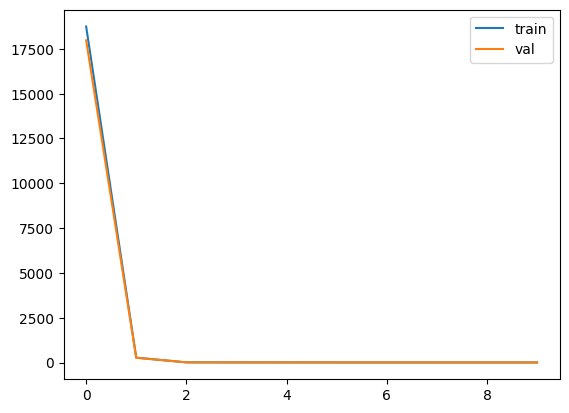

In [5]:
# plot

import matplotlib.pyplot as plt
plt.plot(loss_train, label='train')
plt.plot(loss_val, label='val')
plt.legend(loc='best')

In [21]:
class NeuralNetwork:

    def __init__(self, rng, n_features, n_output, n_neurons_per_layers):
        self.n_features = n_features
        self.n_output = n_output
        self.n_neurons_per_layers = n_neurons_per_layers
        self.params = []
        n_neurons_pre = self.n_features
        for n_neurons in self.n_neurons_per_layers:
            rng, rng_ = jax.randomsplit(rng)
            self.params.append(jax.random.normal(rng_, shape=(n_neurons_pre, n_neurons))*0.1)
            n_neurons_pre = n_neurons
        rng, rng_ = jax.random.split(rng)
        self.params.append(jax.random.normal(rng_, shape=(n_output, n_neurons_pre))*0.1)

    def model(self, x):
        a = x
        for w in self.params[:-1]:
            z = a@w
            a = jax.nn.relu(z)

        return jnp.vdot(a, params[-1])
    
    def loss(self, batch_x, batch_y):
        def squared_error(x,y):
            return (y - self.model(x))**2
        
        return jnp.mean(jax.vmap(squared_error)(batch_x, batch_y))
    
    def grad_loss(self):
        return jax.jit(jax.grad(loss, argnums=(0,)))
    
    def update_params(self, grads, learning_rate):
        new_params = []
        for grad, w in zip(grads[0], params):
            new_params.append(w - learning_rate * grad)
        return new_params

In [20]:
NN = NeuralNetwork(rng, n_features=realx_train.shape[1], n_output=1, n_neurons_per_layers = [32, 32])
NN.model(realx_train)
NN.loss()
NN.update_params(grads= , learning_rate=0.01)